In [52]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
#!/usr/bin/env python
from __future__ import print_function


import random
import numpy as np
from collections import deque
import time
import json
from collections import defaultdict
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf
import pickle
import sys
sys.path.insert(0, '../src/data')
import auxiliary_functions, make_dataset
from auxiliary_functions import convert_miles_to_minutes_nyc, list_of_output_predictions_to_direction
sys.path.insert(0, '../src/models')
from model_mlp import RLNYCTaxiCab

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"




### Average speed of taxis in Manhattan
- In 2014, it dropped to 8.51 MPH. http://www.wnyc.org/story/traffic-speeds-slow-nyc-wants-curb-car-service-growth/
- 8.51 MPH is 3.80431 meters / second

### Geohash units are meters
- http://stackoverflow.com/questions/13448595/geohash-string-length-and-accuracy

In [4]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df, final_data_structure= make_dataset.main()

Opening up data
Group data
Creating the final data structure


In [5]:
# sample of the final data structure
final_data_structure[1110]['Zct8R']

[(14.765, 20, 0.7382499999630875),
 (12.815200000000004, 20, 0.6407599999679622),
 (12.74269230769231, 20, 0.6371346153527588),
 (11.510000000000003, 10, 1.1509999998849003),
 (13.840303030303033, 20, 0.6920151514805509),
 (13.59464285714286, 10, 1.3594642855783396),
 (12.480285714285715, 10, 1.2480285713037687),
 (13.586486486486491, 10, 1.3586486485127842),
 (11.100800000000003, 10, 1.1100799998889923),
 (9.999090909090913, 10, 0.9999090908091004),
 (12.540000000000001, 10, 1.2539999998746),
 (16.846790123456774, 20, 0.8423395061307217),
 (14.20904761904762, 20, 0.7104523809168584),
 (13.19685714285715, 10, 1.3196857141537464),
 (13.012058823529417, 10, 1.3012058822228212),
 (10.919736842105266, 10, 1.0919736841013292),
 (12.727187500000001, 20, 0.6363593749681821),
 (10.53694444444445, 10, 1.0536944443390754),
 (13.375609756097564, 10, 1.3375609754760003),
 (15.676341463414628, 10, 1.5676341461846994),
 (15.99925, 20, 0.7999624999600019),
 (12.792558139534883, 10, 1.2792558138255627

In [6]:
# the data
taxi_yellowcab_df.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff,trip_time_minutes
0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,...,0.0,0.0,0.3,8.8,Zct8X,dr5rsx,1,0,dr5rsx,10
1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,...,0.0,0.0,0.3,19.3,Zct8c,dr5rtk,1,0,dr5rtk,30
2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,...,0.0,0.0,0.3,34.3,Zct5T,dr72j1,1,0,dr72j1,60
3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,...,0.0,0.0,0.3,17.3,Zct8Q,dr5rkc,1,0,dr5rkc,30
4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,...,0.0,0.0,0.3,8.8,Zc4oK,dr5rue,1,0,dr5rue,10
5,5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,...,0.0,0.0,0.3,20.3,Zct9J,dr5ryh,1,18,dr5ryh,30
6,6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,...,0.0,0.0,0.3,27.3,Zct8Q,dr72hc,1,26,dr72hc,40
7,7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,...,0.0,0.0,0.3,10.3,Zct9J,dr5ru7,1,11,dr5ru7,10
8,8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,...,0.0,0.0,0.3,19.3,Zc4oj,dr72mz,1,11,dr72mz,40
9,9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,...,0.0,0.0,0.3,12.8,Zct8R,dr5rkp,1,11,dr5rkp,20


# Finding neighbors from a dropoff geohash
- use gh.neighbors
- Convert these neighbors to an output index from the neural network

In [7]:
gh.neighbors(taxi_yellowcab_df.geohash_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

In [8]:
# Dictionary to convert these distances into the output from the Neural Network
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
list_of_output_predictions_to_direction={0:'nw',1:'n',2:'ne',3:'w',4:'stay',5:'e',6:'sw',7:'s',8:'se'}

# How many different paths are there for a cab driver to take
- 1) Assuming you can go to every geohash (not possible)
- 2) In a day

In [ ]:
print('There are {} possible moves per day - increments of 10 minutes'.format(6*24))

In [ ]:
# how man geohashes can you visit in a day?
print('WIth a full 24 hours day, you can visit {:,} geohashes with an average time of 10 minutes to traverse'.format(
    9**(144+1)-1))

In [ ]:
len(str(9**(144+1)-1))

# Heat Map of the most profitable geohashes

In [ ]:
pickup_sum_fare = taxi_yellowcab_df.groupby('geohash_pickup').sum()['total_amount'].reset_index()


In [ ]:
pickup_sum_fare = pickup_sum_fare.sort_values(by='total_amount',ascending=False)

In [ ]:
pickup_sum_fare['total_amount']= pickup_sum_fare.total_amount.apply(lambda x: round(x))

In [ ]:
# can only plot 2k values on google maps

In [ ]:
#pickup_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

In [ ]:
#plt.figure(figsize=(10,5))
ax = pickup_sum_fare[:50].plot(x='geohash_pickup',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

## Break up the day into ten minute intervals( the time to traverse a geohash of ~3803 meters).
### Note: This code is already run in the make_data.main() call in the first cell
- Aggregate all of the days together so that you have one 24 hour block
- For this 24 hour block, group by five minute periods
- For each period, take the geohash as the key and a list of tuples of ( average fares over the month, trip times in minutes)
- This gives an end result of the average fare and corresponding trip time and ration of fare/trip time for each geohash for a given ten minutes over each day in January

In [34]:

    
taxi_yellowcab_df['trip_time_minutes'] = taxi_yellowcab_df.trip_distance.apply(lambda x: convert_miles_to_minutes_nyc(x))

In [35]:
# distribution of trip times
trip_minutes_grouped = taxi_yellowcab_df.groupby('trip_time_minutes').count()

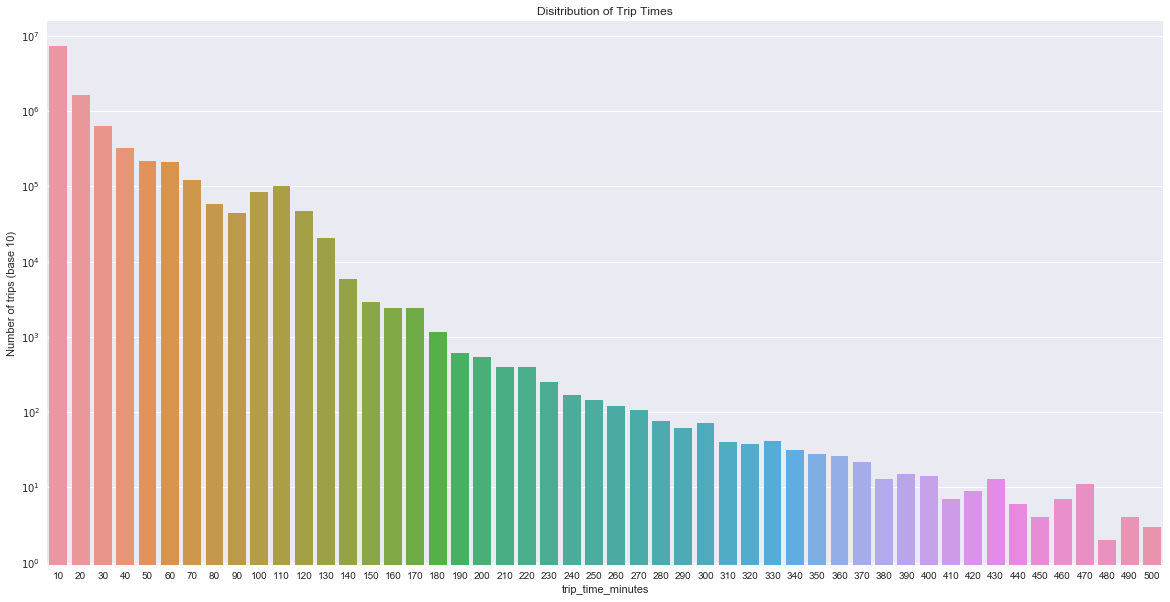

In [36]:
plt.figure(figsize=(20,10))
grid = sns.barplot(x = trip_minutes_grouped['VendorID'].reset_index()['trip_time_minutes'][:50],
            y= trip_minutes_grouped['VendorID'].reset_index()['VendorID'][:50])
grid.set( yscale="log")
plt.ylabel('Number of trips (base 10)')
plt.title('Disitribution of Trip Times')

## Index the geohashes to a number
#### List of possible times

In [9]:
## get a list of unique geohashes
list_of_unique_geohashes = taxi_yellowcab_df.geohash_pickup.unique()
len(list_of_unique_geohashes)

3086

In [10]:
list_of_geohash_index  = defaultdict(int)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_geohash_index [hash_n] = idx

In [11]:
list_of_inverse_heohash_index = defaultdict(str)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_inverse_heohash_index[idx] = hash_n

In [12]:
list_of_inverse_heohash_index

defaultdict(str,
            {0: 'Zct8X',
             1: 'Zct8c',
             2: 'Zct5T',
             3: 'Zct8Q',
             4: 'Zc4oK',
             5: 'Zct9J',
             6: 'Zc4oj',
             7: 'Zct8R',
             8: 'Zct3r',
             9: 'Zct9a',
             10: 'Zct8T',
             11: 'Zct3q',
             12: 'Zct8S',
             13: 'Zct9T',
             14: 'Zc4oM',
             15: 'Zct9W',
             16: 'Zct5w',
             17: 'Zct8W',
             18: 'Zct9B',
             19: 'Zct8V',
             20: 'Zct8P',
             21: 'Zct91',
             22: 'Zct9H',
             23: 'Zct9m',
             24: 'Zct8U',
             25: 'Zct9c',
             26: 'Zct8Y',
             27: 'Zct9e',
             28: 'wAAAA',
             29: 'Zc4oO',
             30: 'Zct6T',
             31: 'Zct9M',
             32: 'Zc4og',
             33: 'Zct5f',
             34: 'Zct9R',
             35: 'Zct8d',
             36: 'Zct9D',
             37: 'Zct9N',
     

In [13]:
hours = [str(_) for _ in range(24)]
minutes = [str(_) for _ in range(0,60,10)]
minutes.append('00')
list_of_time_index =[]
for h in hours:
    for m in minutes:

        list_of_time_index.append(int(str(h)+str(m)))
list_of_time_index = list(set(list_of_time_index))

In [14]:
list_of_time_index

[0,
 2050,
 1540,
 1030,
 520,
 10,
 1550,
 1040,
 530,
 20,
 1050,
 540,
 30,
 550,
 40,
 50,
 2100,
 60,
 2110,
 1600,
 70,
 2120,
 1610,
 1100,
 80,
 2130,
 1620,
 1110,
 600,
 90,
 2140,
 1630,
 1120,
 610,
 100,
 2150,
 1640,
 1130,
 620,
 110,
 1650,
 1140,
 630,
 120,
 1150,
 640,
 130,
 650,
 140,
 150,
 2200,
 160,
 2210,
 1700,
 170,
 2220,
 1710,
 1200,
 180,
 2230,
 1720,
 1210,
 700,
 190,
 2240,
 1730,
 1220,
 710,
 200,
 2250,
 1740,
 1230,
 720,
 210,
 1750,
 1240,
 730,
 220,
 1250,
 740,
 230,
 750,
 240,
 250,
 2300,
 2310,
 1800,
 2320,
 1810,
 1300,
 2330,
 1820,
 1310,
 800,
 2340,
 1830,
 1320,
 810,
 300,
 2350,
 1840,
 1330,
 820,
 310,
 1850,
 1340,
 830,
 320,
 1350,
 840,
 330,
 850,
 340,
 350,
 1900,
 1910,
 1400,
 1920,
 1410,
 900,
 1930,
 1420,
 910,
 400,
 1940,
 1430,
 920,
 410,
 1950,
 1440,
 930,
 420,
 1450,
 940,
 430,
 950,
 440,
 450,
 2000,
 2010,
 1500,
 2020,
 1510,
 1000,
 2030,
 1520,
 1010,
 500,
 2040,
 1530,
 1020,
 510]

In [15]:
taxi_yellowcab_df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'geohash_pickup', 'geohas_dropoff', 'jan_day', 'jan_minute',
       'geohash_dropoff', 'trip_time_minutes'],
      dtype='object')

# Use an Actor Critic Model
- https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html

In [75]:
def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])  
        h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)
        Steering = Dense(1,activation='tanh',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Acceleration = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Brake = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        V = merge([Steering,Acceleration,Brake],mode='concat')          
        model = Model(input=S,output=V)
        print("We finished building the model")
        return model, model.trainable_weights, S

In [5]:
from keras.layers.normalization import BatchNormalization

In [18]:
##Define a simple model where the output is a softmax probability over the eight states
# Inputs will be the time, current geohash-index ()
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
model_mlp = Sequential()
model_mlp.add(Dense(100, input_shape=(2,)))
model_mlp.add(BatchNormalization())
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(500))
model_mlp.add(BatchNormalization())
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(1000))
model_mlp.add(BatchNormalization())
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(9, activation='linear')) 
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               300       
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 500)               50500     
_________________________________________________________________
batch_normalization_8 (Batch (None, 500)               2000      
_________________________________________________________________
activation_12 (Activation)   (None, 500)               0         
__________

In [39]:
model_simple.train_on_batch()

array([  7.44423419e-02,   1.40299603e-01,   1.09284155e-01,
        -1.10768929e-01,   2.07154617e-01,   7.07447007e-02,
         8.54667425e-02,   8.00377224e-03,   2.21517101e-01,
        -2.42102221e-01,  -6.10759258e-02,  -1.45535931e-01,
        -1.65756047e-01,  -4.91893589e-02,   1.73859954e-01,
        -1.49120584e-01,  -2.06316128e-01,   1.65783182e-01,
         7.91345015e-02,   2.13200897e-01,  -1.62327856e-01,
        -8.43094885e-02,  -1.75167412e-01,  -1.21087916e-01,
        -4.51998860e-02,   3.12203523e-02,   2.28695258e-01,
         1.63484603e-01,   7.42360950e-02,   1.27013892e-01,
        -8.62635672e-02,  -2.11581349e-01,   7.32784197e-02,
        -1.53000727e-01,   6.03147633e-02,  -5.34382761e-02,
        -3.49058807e-02,   1.04924574e-01,   1.95071340e-01,
        -9.93548036e-02,  -2.04159021e-01,   3.50150615e-02,
        -1.07811205e-01,   9.01406482e-02,  -7.40328580e-02,
        -1.87253892e-01,   1.51542857e-01,  -1.61637306e-01,
        -1.88307926e-01,

In [20]:
model_simple.predict(X)

array([[  9.99218583e-01,   3.69379142e-13,   1.08317809e-22,
          5.93804972e-21,   4.04363523e-16,   6.70722822e-25,
          9.62229051e-26,   3.95748365e-12,   7.81367882e-04]], dtype=float32)

In [21]:
list_of_geohash_index[np.random.choice(list_of_unique_geohashes)] # index of geohash

37

In [259]:
np.random.choice(list_of_time_index) # time

1410

In [271]:
np.array([[np.random.choice(list_of_time_index),
                     list_of_geohash_index[np.random.choice(list_of_unique_geohashes)]]])
    

array([[ 605, 2775]])

In [278]:
random.randrange(ACTIONS)

8

# Show that the model can overfit a small traning set

In [241]:
starting_geohash = 'Zc4o-'
geohash_index = list_of_geohash_index['Zc4o-']
starting_time = 110
state_1 = np.array([])

In [ ]:
# time, geohash for predictions

In [242]:
gh.neighbors('Zc4o-')

{'e': 'Zc4qU',
 'n': 'Zc4o_',
 'ne': 'Zc4qV',
 'nw': 'Zc4o9',
 's': 'Zc4o7',
 'se': 'Zc4qR',
 'sw': 'Zc4o5',
 'w': 'Zc4o8'}

In [281]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_shape= (2,)))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(500, activation='relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(500, activation='relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(100, activation='relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(9, activation='softmax')) ## predict which geohash to move to next
adam = Adam(lr=1e-1)
#model_mlp.load_weights("model_mlp_million.h5")
model_mlp.compile(loss='mse',optimizer=adam)

In [282]:
X= np.array([[2310,20]])

In [283]:
model_mlp.predict(X)

array([[  0.00000000e+00,   2.84188668e-22,   0.00000000e+00,
          5.69559885e-28,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   3.87473846e-35,   0.00000000e+00]], dtype=float32)

In [284]:
model_mlp.predict(X)

array([[  0.00000000e+00,   2.84188668e-22,   0.00000000e+00,
          5.69559885e-28,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   3.87473846e-35,   0.00000000e+00]], dtype=float32)

# Hyperas results for MLP model

>model_mlp = Sequential()
- model_mlp.add(Dense({{choice([32, 64,126, 256, 512, 1024])}},
                        activation='relu', input_shape= (2,)))
-  model_mlp.add(Dropout({{uniform(0, .5)}}))
- model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
- model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
- model_mlp.add(Dropout({{uniform(0, .5)}}))
- model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
- model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
- model_mlp.add(Dropout({{uniform(0, .5)}}))
- model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
- model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
- model_mlp.add(Dropout({{uniform(0, .5)}}))
- model_mlp.add(Dense(9))
- model_mlp.add(Activation({{choice(['softmax','linear'])}}))
- model_mlp.compile(loss={{choice(['categorical_crossentropy','mse'])}}, metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})



> model_mlp.fit(x_train, y_train,
              batch_size={{choice([16, 32, 64, 128])}},
              epochs=50,
              verbose=2,
              validation_data=(x_test, y_test))
    score, acc = model_mlp.evaluate(x_test, y_test, verbose=0)





>Best performing model chosen hyper-parameters:
- {'Activation': 1, 'Activation_1': 0, 'Activation_2': 0, 'Activation_3': 0, 'Dense': 0, 'Dense_1': 1, 'Dense_2': 1, 'Dense_3': 5, 'Dropout': 0.056229870832780804, 'Dropout_1': 0.1603763880022983, 'Dropout_2': 0.3671073489296299, 'Dropout_3': 0.3462695171578595, 'batch_size': 0, 'loss': 1, 'optimizer': 2}
- Interesting, use MSE with softmax

# GPU vs CPU

In [17]:
gpu_speed_1k = 55
cpu_speed_1k = 59


In [19]:
# How much time is saved over 1,000,000 training examples?
print('We save about {} minutes over 1 million training iterations'.format(round((1000000/1000 * \
                                                                                     (cpu_speed_1k -gpu_speed_1k ))/60)))

We save about 67 minutes over 1 million training iterations


# DQN approach

### Investigate the loss over time

In [54]:
with open(r"mlp_model/loss_over_time_linear", "rb") as input_file:
     loss_over_time_mlp = pickle.load(input_file)



In [56]:
len(loss_over_time_mlp)

995000

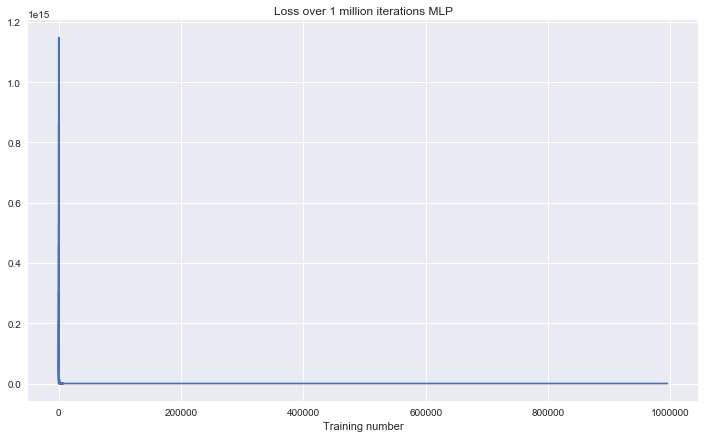

In [60]:
plt.figure(figsize=(12,7))
plt.plot(loss_over_time_mlp)
plt.title('Loss over 1 million iterations MLP')
plt.xlabel('Training number')

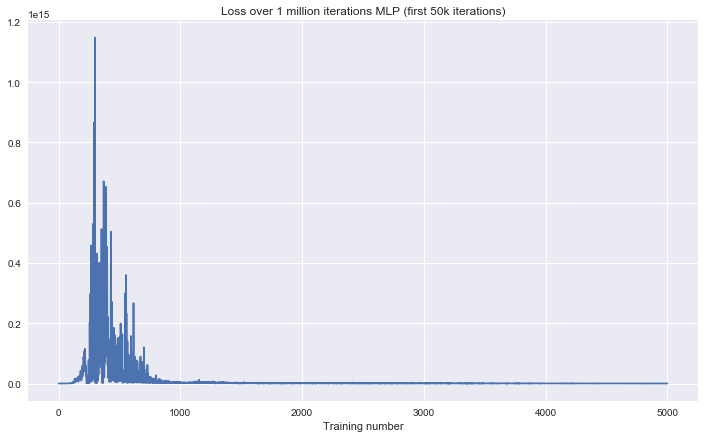

In [64]:
plt.figure(figsize=(12,7))
plt.plot(loss_over_time_mlp[:5000])
plt.title('Loss over 1 million iterations MLP (first 50k iterations)')
plt.xlabel('Training number')

## Investigate the fare earned in a naive approach vs 1 million training iterations

In [81]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TIMESTEP 0 / STATE observe / EPSILON 0.1 / ACTION 8 / REWARD 0.679199999986 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 0.4536769390106201
We finished a day!
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
We finished a day!
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
We finished a day!
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action-

In [61]:
total_fare_received_over_time_no_train = total_fare_received_over_time
naive_fare_over_time_no_train = naive_fare_over_time

### No training, fares between RL and naive

In [ ]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Test','save_model':False,'model_weights_load':'model_mlp.h5',
               'save_model_weights':'mlp_linear.h5'}# for the million parameter weights
loss_list, total_fare_received_over_time_onemillion_training,list_of_geohashes_visited, \
naive_fare_over_time_onemillion_training, days_driven, naive_geohashes =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

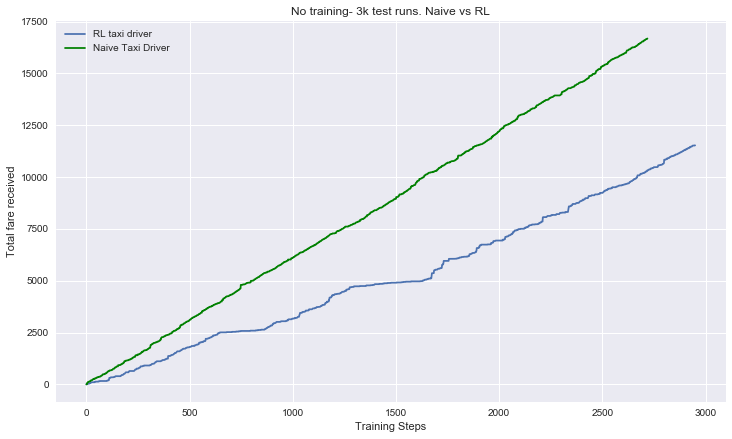

In [62]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_no_train, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_no_train, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('No training- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

## One million training iterations, fares between RL and Naive

In [88]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Run','model_weights_load':'mlp_model/model_mlp_linear_onemillion.h5',
      'save_model_weights':'mlp_linear_1million.h5'} # for the million parameter weights

loss_list, total_fare_received_over_time_onemillion_training,list_of_geohashes_visited, \
naive_fare_over_time_onemillion_training, days_driven, naive_geohashes =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

Now we load weight
Weight load successfully
TIMESTEP 0 / STATE observe / EPSILON 0.1 / ACTION 3 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 0.8803761005401611
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
We finished a day!
----------Random Action----------
We finished a day!
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
---------

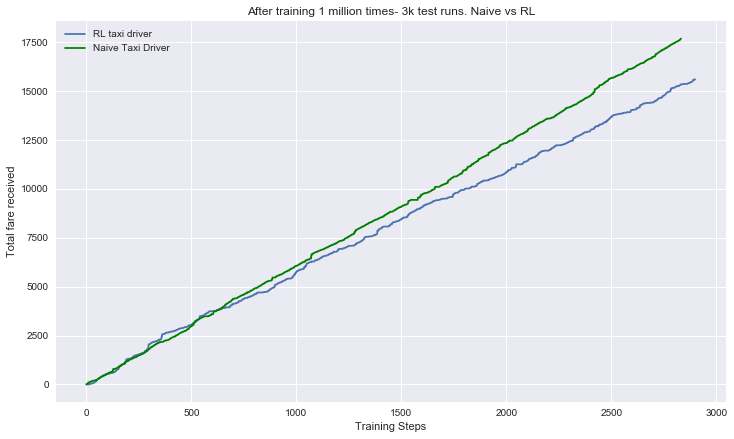

In [89]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_onemillion_training, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_onemillion_training, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 1 million times- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

### 1.5 million training iterations, fares between rl and naive

In [94]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Run','model_weights_load':'mlp_model/model_mlp_linear_1.5million.h5',
      'save_model_weights':'mlp_linear_1.5million.h5'} # for the million parameter weights


loss_list, total_fare_received_over_time_1_5million_training,list_of_geohashes_visited, \
naive_fare_over_time_1_5million_training, days_driven, naive_geohashes =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

Now we load weight
Weight load successfully
TIMESTEP 0 / STATE observe / EPSILON 0.1 / ACTION 8 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 1.002851963043213
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
We finished a day!
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action------

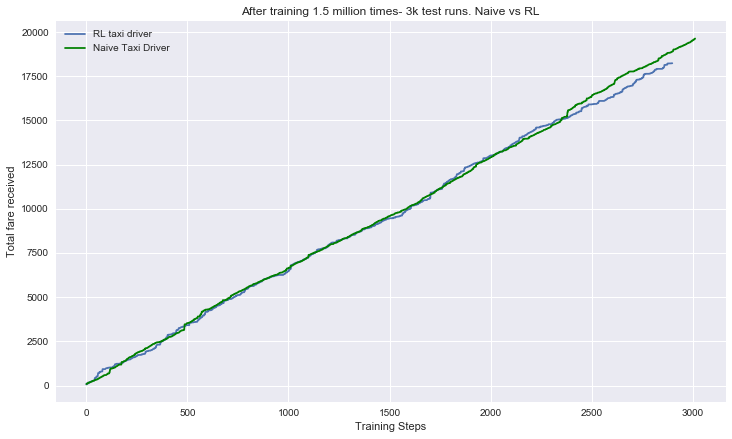

In [95]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_1_5million_training, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_1_5million_training, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 1.5 million times- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

# Total fare received over one million training examples

In [72]:
with open(r"mlp_model/rl_total_fare_time_linear", "rb") as input_file:
     rl_total_fare_time_linear = pickle.load(input_file)

In [73]:
with open(r"mlp_model/naive_fare_time_linear", "rb") as input_file:
     naive_fare_time_linear = pickle.load(input_file)

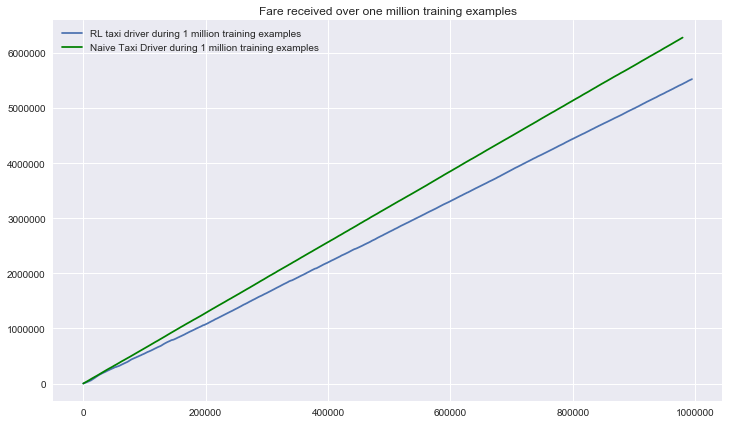

In [76]:
plt.figure(figsize=(12,7))
plt.plot(rl_total_fare_time_linear , label = 'RL taxi driver during 1 million training examples')
plt.plot(naive_fare_time_linear, color='green',label='Naive Taxi Driver during 1 million training examples')
plt.legend()
plt.title('Fare received over one million training examples')

In [68]:
%load_ext autoreload
%autoreload 2


# Visualize the path taken

In [204]:
import geohash as geohash

In [206]:
geohash.decode('Zct7Z')

(54.11865234375, 176.46240234375)

In [207]:
gh.decode('Zct-p')

{'h': 0.005493, 'lat': 40.701599, 'lon': -73.844604, 'w': 0.010986}

In [233]:
list_of_geohashes_visited

['ZcvUS',
 'ZcvUF',
 'Zct-u',
 'Zct-p',
 'Zct-i',
 'Zct71',
 'Zct7e',
 'Zct7Z',
 'Zct7S',
 'Zct7F',
 'Zct5u',
 'Zct5p',
 'Zct5i',
 'Zct41',
 'Zct4e',
 'Zct4Z',
 'Zct4S',
 'Zct4F',
 'Zctyu',
 'Zctyp',
 'Zctyi',
 'Zctn1',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'ZeRNU',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',
 'Zct2I',
 'Zct8U',
 'Zct27',
 'Zct24',
 'Zct2n',
 'Zct2k',
 'Zct2L',


In [229]:
decoded_rl = [gh.decode(i) for i in list_of_geohashes_visited]
for line in decoded_rl:
    print(str(line['lat'])+',',line['lon'])

40.718078, -73.811645
40.712585, -73.822631
40.707092, -73.833618
40.701599, -73.844604
40.696105, -73.85559
40.690612, -73.866577
40.685119, -73.877563
40.679626, -73.888549
40.674133, -73.899536
40.66864, -73.910522
40.663146, -73.921508
40.657653, -73.932495
40.65216, -73.943481
40.646667, -73.954467
40.641174, -73.965454
40.635681, -73.97644
40.630187, -73.987426
40.624694, -73.998413
40.619201, -74.009399
40.613708, -74.020385
40.608215, -74.031372
40.602722, -74.042358
40.729064, -73.998413
40.723571, -74.009399
40.718078, -74.020385
40.712585, -74.031372
40.707092, -74.042358
40.701599, -74.053344
40.696105, -74.064331
40.729064, -73.998413
40.723571, -74.009399
40.718078, -74.020385
40.712585, -74.031372
40.707092, -74.042358
40.701599, -74.053344
40.696105, -74.064331
40.729064, -73.998413
40.723571, -74.009399
40.718078, -74.020385
40.712585, -74.031372
40.707092, -74.042358
40.701599, -74.053344
40.696105, -74.064331
40.729064, -73.998413
40.723571, -74.009399
40.718078, -74

In [232]:
naive_geohashes

['Zct2I',
 'ZeRYC',
 'Zct8V',
 'Zct8X',
 'Zct8c',
 'Zct8e',
 'Zct8f',
 'Zct8d',
 'Zct9C',
 'Zct8U',
 'Zct2_',
 'Zct9C',
 'Zct8d',
 'Zct8X',
 'Zct9I',
 'Zct9K',
 'Zct81',
 'Zct82',
 'Zct80',
 'Zct8c',
 'Zct8U',
 'Zct8T',
 'Zct8Q',
 'Zct27',
 'Zct25',
 'Zct9C',
 'Zct9B',
 'Zct9G',
 'Zct9D',
 'Zct9I',
 'Zct8X',
 'Zct8U',
 'Zct8R',
 'Zct26',
 'Zct25',
 'Zct24',
 'Zct2y',
 'Zct25',
 'Zct28',
 'Zct2z',
 'Zct25',
 'Zct24',
 'Zct2t',
 'Zct2v',
 'Zct2s',
 'Zct2p',
 'Zct2j',
 'Zct2h',
 'Zct8d',
 'Zct9C',
 'Zct8W',
 'Zct8d',
 'Zct8f',
 'Zct8e',
 'Zct8d',
 'Zct8f',
 'Zct8c',
 'Zct8W',
 'Zct8V',
 'Zct9C',
 'Zct8V',
 'Zct2_',
 'Zct29',
 'Zct3i',
 'Zct3o',
 'Zct8c',
 'Zct8d',
 'Zct8f',
 'Zct9I',
 'Zct9I',
 'Zct8X',
 'Zct9I',
 'Zct8d',
 'Zct8c',
 'Zct8e',
 'Zct8x',
 'Zct8y',
 'Zct8n',
 'Zct8l',
 'Zct8n',
 'Zct9I',
 'Zct8f',
 'Zct8c',
 'Zct8d',
 'Zct8X',
 'Zct8V',
 'Zct8X',
 'Zct8V',
 'Zct8X',
 'Zct8U',
 'Zct8d',
 'Zct8c',
 'Zct8b',
 'Zct8a',
 'Zct8b',
 'Zct8c',
 'Zct8U',
 'Zct27',
 'Zct28',
 'Zct29',


In [231]:
decoded_naive = [gh.decode(i) for i in naive_geohashes]
for line in decoded_naive:
    print(str(line['lat'])+',',line['lon'])

40.696105, -74.064331
41.31134, -72.932739
40.734558, -73.998413
40.734558, -73.987426
40.729064, -73.97644
40.729064, -73.965454
40.734558, -73.965454
40.734558, -73.97644
40.740051, -73.987426
40.729064, -73.998413
40.734558, -74.009399
40.740051, -73.987426
40.734558, -73.97644
40.734558, -73.987426
40.740051, -73.97644
40.740051, -73.965454
40.734558, -73.954467
40.729064, -73.943481
40.729064, -73.954467
40.729064, -73.97644
40.729064, -73.998413
40.723571, -73.987426
40.718078, -73.998413
40.723571, -74.009399
40.723571, -74.020385
40.740051, -73.987426
40.745544, -73.998413
40.751037, -73.987426
40.745544, -73.987426
40.740051, -73.97644
40.734558, -73.987426
40.729064, -73.998413
40.723571, -73.998413
40.718078, -74.009399
40.723571, -74.020385
40.718078, -74.020385
40.718078, -74.031372
40.723571, -74.020385
40.729064, -74.020385
40.723571, -74.031372
40.723571, -74.020385
40.718078, -74.020385
40.712585, -74.020385
40.712585, -74.009399
40.707092, -74.020385
40.701599, -74.02

## Loss after 600k iterations


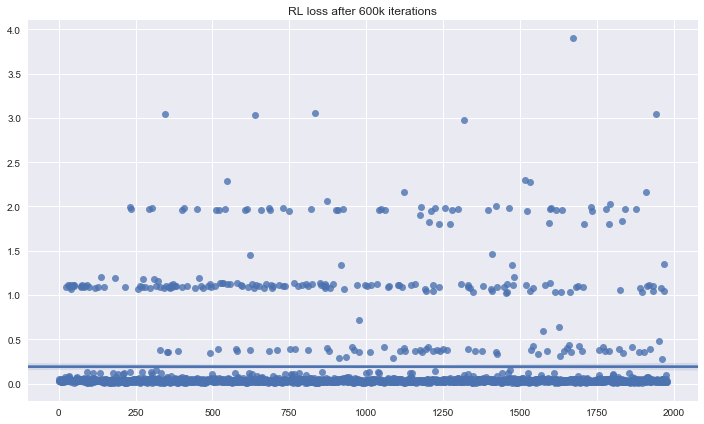

In [136]:
plt.figure(figsize=(12,7))
sns.regplot(np.array([_ for _ in range(len(loss_list))]),np.array(loss_list))  # 50 k
plt.title('RL loss after 600k iterations')

In [127]:
# Naive agent average fare
naive_fare_over_time.pop()/days_driven

616.26572927448592

In [124]:
### RL agent average daily fare
total_fare_received_over_time.pop()/days_driven

641.32206235370268

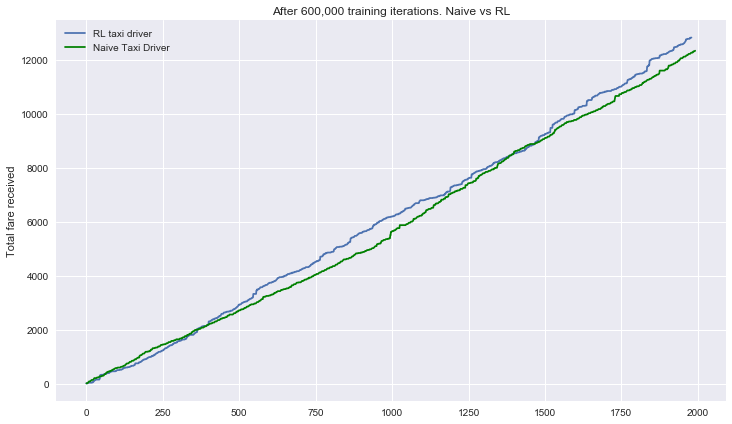

In [121]:
plt.figure(figsize = (12,7))
plt.plot(total_fare_received_over_time, label = 'RL taxi driver')
plt.plot(naive_fare_over_time, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After 600,000 training iterations. Naive vs RL')
plt.ylabel('Total fare received')

# Initial Loss & Loss after 1million training iterations - MLP

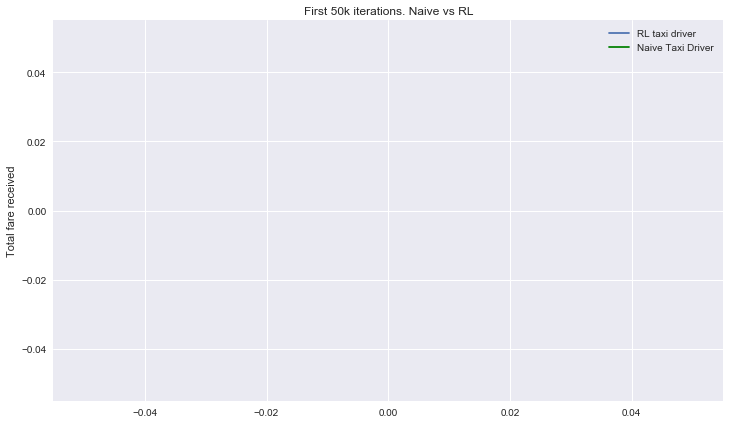